In [23]:
import torch
import numpy as np

from conditional_rate_matching.models.generative_models.crm import uniform_pair_x0_x1
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders_crm

from conditional_rate_matching.models.generative_models.crm import (
    CRM
)

from conditional_rate_matching.models.trainers.crm_trainer import CRMTrainer
from conditional_rate_matching.configs.configs_classes.config_crm import CRMConfig
from conditional_rate_matching.models.trainers.ddsm_trainer import ScoreNetMLP
from conditional_rate_matching.models.generative_models.ddsm import Euler_Maruyama_sampler
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from conditional_rate_matching.models.metrics.fid_metrics import fid_nist

from conditional_rate_matching.models.pipelines.sdes_samplers.samplers_utils import sample_from_dataloader


In [29]:
from conditional_rate_matching.configs.experiments_configs.crm.crm_experiments_nist import experiment_nist
from conditional_rate_matching.models.temporal_networks.temporal_networks_config import TemporalMLPConfig,TemporalDeepMLPConfig
from conditional_rate_matching.data.image_dataloader_config import NISTLoaderConfig
from conditional_rate_matching.data.dataloaders_utils import get_data


configs = experiment_nist(temporal_network_name="unet_conv")
configs.data1 = NISTLoaderConfig(flatten= False,as_image=True)
training_dl, test_dl = get_data(configs.data1)

max_test_size = 100


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 128.35it/s]


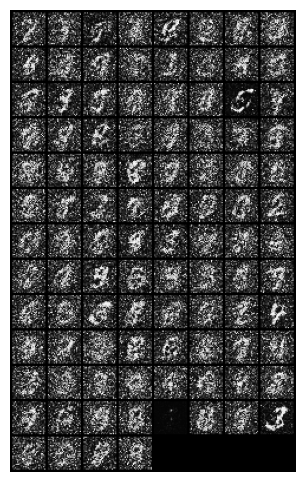

In [30]:
from conditional_rate_matching.configs.config_files import ExperimentFiles
experiment_files = ExperimentFiles(experiment_name="ddsm",experiment_type="test",experiment_indentifier="1705070668")

RESULTS = torch.load(experiment_files.best_model_path)
score_model = RESULTS["model"]

# generate samples from trained model
torch.set_default_dtype(torch.float32)
score_model.eval()

device = 'cpu'

sample_batch_size = 64
sampler = Euler_Maruyama_sampler  ## Generate samples using the specified sampler.

samples = sampler(score_model, (28, 28, 2),
                  batch_size=max_test_size,
                  max_time=4,
                  min_time=0.01,
                  num_steps=100,
                  eps=1e-5,
                  device=device)

samples = samples.clamp(0.0, 1.0)

sample_grid = make_grid(samples[:, None, :, :, 0].detach().cpu(), nrow=int(np.sqrt(sample_batch_size)))
sample_grid = sample_grid.permute(1, 2, 0).cpu()
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid, vmin=0., vmax=1.)
plt.show()

In [33]:
samples.shape

torch.Size([100, 28, 28, 2])

In [6]:
from torch.distributions import Bernoulli

In [44]:
pixel_probability = samples[:,:,:,0]
pixel_distribution = Bernoulli(pixel_probability)
generative_sample = pixel_distribution.sample()

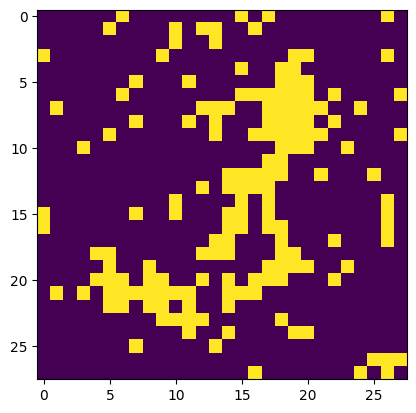

In [41]:
plt.imshow(pixels[-5])

In [22]:
from conditional_rate_matching.models.metrics.fid_metrics import fid_nist

In [28]:
test_sample = sample_from_dataloader(training_dl, sample_size=max_test_size).to(torch.device(device))

In [ ]:
fid_nist_metrics = fid_nist(generative_sample, test_sample,config.data1.dataset_name,torch.device(device))

In [46]:
test_sample.shape

torch.Size([100, 784])

In [45]:
generative_sample.shape

torch.Size([100, 28, 28])